# macro_scale_model_post_processing.m
Dr. Brittany Bannish, University of Central Oklahoma  
Stephen B. Gregg, University of Central Oklahoma  
Updated on 2/8/2017

This MATLAB file calculates and plots results from a macro scale model
of blood clot degredation. 

## Output:
 
1. Calculations
     1. front_velocity
     1. std_front_velocity
     1. degradation_rate
     1. std_degradation_rate
1. Plots
     1. Fiber Height Degradation: degradation height vs time
     1. Fiber Degradation: fraction of fibers degraded vs time
     1. Total Fibers Degraded: number of fibers degraded vs time

In [1]:
close all
clear all
format long

In [16]:
graphics_toolkit ("gnuplot");
expCode = '2022-12-20-1600';
fileCode = 'tPA425_PLG2_tPA01_into_and_along_Q2.dat';
folder = strcat('../../data/', expCode);

In [3]:
% binary formatting: type sun for sun and lin for linux
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
arch = 'lin';
if arch == 'sun',
    binaryformat = 'ieee-be';
else 
    binaryformat = 'ieee-le';    
end;
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

## global variables
- `N`: number of nodes in one row in horizontal direction 
- `F`: number of nodes in one column in vertical direction
- `number_of_simulations`: number of independent macroscale model simulations performed
- `tf`: final time in macroscale model (in seconds)
- `degradable_fibers_constant`: number of degradable fibers in the clot  
**Note**: the above quantities (`N`, `F`, `number_of_simulations`, `final_simulation_time`) should match the corresponding numbers from the macroscale model code that was used to generate the data
- `total_fibers`: total number of fibers in clot (including ghost edges)  
              (this counts the number of fibers in the lattice diagram)

In [4]:
N = 93;  %93;%87;%93;%117;%93;%83;
F = 121;   %121;%113;%121;%152;%121;%108;
Ffree = 29;
number_of_simulations = 10;
final_simulation_time = 20*60; %20*60;
total_fibers = (2*N-1)*F + N*(F-1);
number_of_degradable_fibers_constant = total_fibers - (3*N-1)*(Ffree-1); %28700; %25761;%40833;%25761;%20501; %this is num-enoFB from macro Fortran code

## open files created with Fortran
`fids(k)` `'[file]'_[tPA conc]_[PLG conc]_[insert]_[insert]_[quartile]`

- `fids(1)` 'lastmove_': gives the last time step at which the front moves for each x-location
- `fids(2)` 'Nsave_': number of time points per simulation
- `fids(7)` 'deg_': 
- `fids(8)` 'move': 
- `fids(9)` 'plot':
- `fids(10)` 'tsave': 
- `number_of_time_points`: gives the total number of entries in time-dependent vectors. So if `final_simulation_time`=20*60 and we save every 10 seconds, then there are 1200/10+1=121 saved time points

In [18]:
fids(1) = fopen(strcat(folder, '/lastmove_', fileCode), 'r', binaryformat);
  last_move = fread(fids(1), [N,number_of_simulations], 'int');
  fclose(fids(1));
fids(2) = fopen(strcat(folder, '/Nsave_', fileCode), 'r', binaryformat);
  Nsave = fread(fids(2), inf, 'int');
  number_of_time_points = Nsave(1)+1;
  fclose(fids(2));
fids(7) = fopen(strcat(folder, '/deg_', fileCode), 'r', binaryformat);
fids(8) = fopen(strcat(folder, '/move_', fileCode), 'r', binaryformat);
fids(9) = fopen(strcat(folder, '/plot_', fileCode), 'r', binaryformat);
fids(10) = fopen(strcat(folder, '/tsave_', fileCode), 'r', binaryformat);

## calculate front velocity and mean degradation rate

ii =  1
    __axis_label__ at line 31 column 3
    xlabel at line 51 column 8
    __axis_label__ at line 31 column 3
    ylabel at line 53 column 8
ii =  2
ii =  3
ii =  4
ii =  5
ii =  6
ii =  7
ii =  8
ii =  9
ii =  10
front_velocity =  11.81600033487164
std_front_velocity =  2.003801292990711


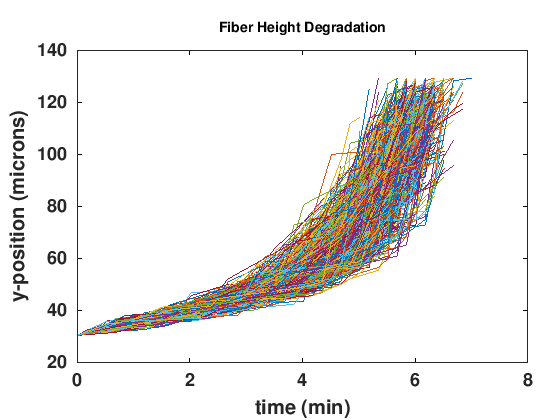

In [19]:
for ii = 1:number_of_simulations
    ii
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %% calculate front velocity
    %%
    %% move: gives the saved-time-step at which the front moves for each x location
    %% degradation_height: gives in each row the successive y-positions (in microns) of x-location corresponding to row number
    %% stopwatch_time: gives the simulation time at which each entry was saved
    %% 
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    move = fread(fids(8), [N, N], 'int');
    degradation_height = fread(fids(9), [N, N], 'double');
    stopwatch_time(ii, 1:number_of_time_points) = fread(fids(10), number_of_time_points, 'double');

    xy_slope = zeros(1, N);

    % to get the time in minutes, divide stopwatch_time by 60
    simulation_stopwatch_time = stopwatch_time(ii, 1:number_of_time_points)/60;

    % fit a line to each x-location data (micron vs. minutes)
    for i=1:N
        % form a vector of timesteps
        timestep_of_moves = 0;
        y_change_stopwatch_time = 0;
        
        % if for some reason last_move isn't correct, this seems to work....
        % indexmove = find(move(:, i)==0, 1, 'first');
        
        % only look at the entries of "move" that actually correspond to the front moving. i.e., ignore 0 entries
        % timestep_of_moves = move(1:indexmove-1, i);
        
        % only look at the entries of "move" that actually correspond to the front moving. i.e., ignore 0 entries
        timestep_of_moves = move(1:last_move(i, ii), i);
        for j = 1:length(timestep_of_moves)
            % take the times (in minutes) corresponding to the times that the front moved
            y_change_stopwatch_time(j) = simulation_stopwatch_time(timestep_of_moves(j)); 
        end

        % plot y-position (in microns) of the front in the ith x-location vs. the time (in minutes)
        % plot(y_change_stopwatch_time,degradation_height(i,1:indexmove-1))
        
        % fit a line to the above plot excluding the first time point
        % [linefit_slope_yint_velocity] = polyfit(y_change_stopwatch_time(2:end), degradation_height(i, 2:indexmove-1), 1); 
        
        % plot y-position (in microns) of the front in the ith x-location vs. the time (in minutes)
        plot(y_change_stopwatch_time, degradation_height(i, 1:last_move(i, ii)))
        
        %fit a line to the above plot excluding the first time point
        [linefit_slope_yint_velocity] = polyfit(y_change_stopwatch_time(2:end), degradation_height(i, 2:last_move(i,ii)), 1); 
        
        xy_slope(i) = linefit_slope_yint_velocity(1); 

        hold all

    end
    
    xlabel('time (min)', 'FontSize', 20, 'FontWeight', 'b')
    ylabel('y-position (microns)', 'FontSize', 20, 'FontWeight', 'b')
    title('Fiber Height Degradation', 'FontSize', 14)
    set(gca, 'FontSize', 18, 'FontWeight', 'bold')

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %% front velocity calculations (excludes first time point)
    %%
    %% simulation_front_velocity: average front velocity (in microns/min) over all x-locations
    %% simulation_std_front_velocity: standard deviation across all x-locations
    %% aggregate_simulation_front_velocity(ii): stores simulation_front_velocity for each simulation
    %% aggregate_simulation_std_front_velocity(ii): stores simulation_std_front_velocity for each simulation
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    simulation_front_velocity = mean(xy_slope);
    simulation_std_front_velocity = std(xy_slope);
    aggregate_simulation_front_velocity(ii) = simulation_front_velocity;
    aggregate_simulation_std_front_velocity(ii) = simulation_std_front_velocity;

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %% THIS IS THE MEAN DEGRADATION RATE PART
    %%
    %% degradation_status: 
    %%      -1: ghost edge
    %%      <-1: time (in seconds) at which the fiber degraded 
    %%      0: fiber is undegraded
    %% 
    %%
    %% 
    %%
    %%
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    degradation_status_vector = fread(fids(7), number_of_time_points*total_fibers, 'double');
    degradation_status_matrix = zeros(total_fibers, number_of_time_points+1);

    for i = 2:(number_of_time_points+1)
        %%%%%%%%%%
        % Makes a big matrix with degradation states.
        % The first column is the initial condition, and then each subsequent column is the degradation status of each edge at each saved time point
        %%%%%%%%%%
        degradation_status_matrix(:,i) = degradation_status_vector(((i-2)*total_fibers+1):(i-1)*total_fibers)';
    end

    %%%%%%%%%%%
    % find the first place in the column that the degradation state is 0. 
    % i.e., the first place degradation hasn't happened. 
    % This will help identify the total number of degradable fibers in the clot
    %%%%%%%%%%%
    
    first_degradable_fiber = find(degradation_status_matrix(:,2)==0, 1, 'first');
    
    % total number of degradable edges = total number of edges in clot (including ghost edges) minus the number from above plus 1. 
    % This should equal fibnum.
    number_of_degradable_fibers_calculated = total_fibers - first_degradable_fiber + 1;
    
    for j=2:(number_of_time_points+1)
        % calculate the total number of degraded edges at each saved time step
        number_of_degraded_fibers(j-1) = length(find(degradation_status_matrix(first_degradable_fiber:end, j)<0)); 
    end

    % calculate the fraction of degraded edges at each saved time point
    fraction_of_degraded_fibers = number_of_degraded_fibers/number_of_degradable_fibers_calculated; 

    %matrix of fraction of degraded edges at each time
    aggregate_fraction_of_degraded_fibers(:, ii) = fraction_of_degraded_fibers; 
    %matrix of number of degraded edges at each time
    aggregate_number_of_degraded_fibers(:, ii) = number_of_degraded_fibers; 

end

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%% 
%%
%% front_velocity: average over all simulations and all x locations for each trial (micron/min; excludes first time points)
%% 
%%
%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


front_velocity = mean(aggregate_simulation_front_velocity)
std_front_velocity = mean(aggregate_simulation_std_front_velocity) 
save(strcat(folder, '/mspeed_', fileCode), 'front_velocity', '-ascii')

## Degradation Rate

    __axis_label__ at line 31 column 3
    xlabel at line 51 column 8
    __axis_label__ at line 31 column 3
    ylabel at line 53 column 8
degradation_rate =  17.83110809740228
std_degradation_rate =    2.578510831171792e-02


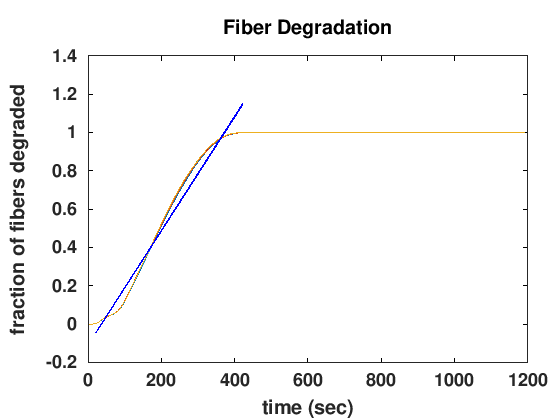

In [20]:
figure
for j = 1:number_of_simulations
    % plot the fraction of fibers degraded at each time point
    plot(stopwatch_time(j, :), aggregate_fraction_of_degraded_fibers(:, j)) 
    hold all
end

xlabel('time (sec)', 'FontSize', 20, 'FontWeight', 'b')
ylabel('fraction of fibers degraded', 'FontSize', 20, 'FontWeight', 'b')
title('Fiber Degradation', 'FontSize', 14)
set(gca, 'FontSize', 18, 'FontWeight', 'bold')

fclose(fids(7));

% find the time point at which lysis begins and ends for each run
for j = 1:number_of_simulations
    % Find the first place where degradation is 100% complete
    timepoint_end_of_degradation = find(aggregate_fraction_of_degraded_fibers(:, j)==1, 1, 'first');
    
    % Find the first place degradation starts
    timepoint_start_of_degradation(j) = find(aggregate_fraction_of_degraded_fibers(:, j)>0, 1, 'first');
    
    if length(timepoint_end_of_degradation)==0 
        % if 100% lysis didn't happen in the given run
        % take the "end of degradation" to be the last entry of the Per_mat matrix
        timepoint_furthest_degradation(j) = length(aggregate_fraction_of_degraded_fibers(:, j)); 
    else 
        % if 100% lysis DID happen in the given run
        % take the "end of degradation" to be the entry at which 100% lysis was first achieved
        timepoint_furthest_degradation(j) = timepoint_end_of_degradation;
    end
    

    % define the "time" that we're interested in to be the entries/saved time
    % points for which degradation actually occurred. So start the degradation
    % time at the 1st place degradation occurred, and finish when you reach
    % 100% lysis, or the end of the run, whichever comes first.
    timepoints_of_degradation = timepoint_start_of_degradation(j):timepoint_furthest_degradation(j); 

    % fit a line from the first place the slope between 2 consecutive seconds is
    % >=tol to the last place the slope is >=tol
    % calculate the slope between the first place degradation occurs and the time point right before that
    mslope(1) = aggregate_fraction_of_degraded_fibers(timepoints_of_degradation(1), j); 
    for i = 2:length(timepoints_of_degradation)
        % calculate the slope between all pairs of successive time points
        mslope(i) = aggregate_fraction_of_degraded_fibers(timepoints_of_degradation(i), j) - aggregate_fraction_of_degraded_fibers(timepoints_of_degradation(i-1), j);
    end
    
    % set the tolerance that we will use to determine the degradation rate.
    % potentially need to make this 1e-4. fiddle with it if results look bad
    tol = 1e-3; 
    
    % find the first place the slope is >= to the tolerance
    left = find(mslope>=tol, 1, 'first'); 
    
    % find the last place the slope is >= to the tolerance
    right=find(mslope>=tol,1,'last'); 
    
    if right>length(timepoints_of_degradation)
       right = length(timepoints_of_degradation);
    end
    
    % redefine the time so that we're only looking at the places where the slope is greater than the tolerance
    timepoints_of_degradation_shifted = timepoints_of_degradation(left:right); 
    
    % fit a line to the data fraction of fibers degraded vs. time (in sec)
    [linefit_slope_yint_degradation1] = polyfit(stopwatch_time(j, timepoints_of_degradation_shifted)', aggregate_fraction_of_degraded_fibers(timepoints_of_degradation_shifted, j), 1); 
    
    % save this slope for each of the 10 runs
    degradation1_slope(j)=linefit_slope_yint_degradation1(1); 
    
    % plot the fitted lines
    plot(stopwatch_time(j, timepoints_of_degradation_shifted)', linefit_slope_yint_degradation1(1)*(stopwatch_time(j, timepoints_of_degradation_shifted)) + linefit_slope_yint_degradation1(2), 'b') 

    % fit a line to the data fraction of fibers degraded vs. time (in min)
    [linefit_slope_yint_degradation2] = polyfit(stopwatch_time(j,timepoints_of_degradation_shifted)'/60, aggregate_fraction_of_degraded_fibers(timepoints_of_degradation_shifted, j), 1);
    
    % save this slope for each of the 10 runs
    degradation2_slope(j) = linefit_slope_yint_degradation2(1);
end

% mean degradation rate over 10 runs, measured in percent of total fibers/min 
degradation_rate=100*mean(degradation2_slope) 

% standard deviation over 10 runs
std_degradation_rate=100*std(degradation2_slope) 

save(strcat(folder, '/mdeg_', fileCode), 'degradation_rate', '-ascii')

    __axis_label__ at line 31 column 3
    xlabel at line 51 column 8
    __axis_label__ at line 31 column 3
    ylabel at line 53 column 8


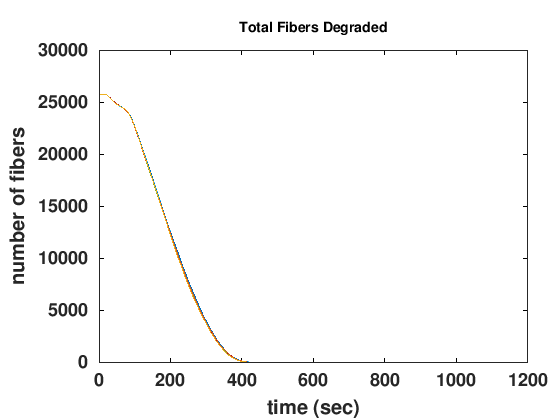

In [21]:
% plot the number of fibers in the clot as a function of time
figure
for j = 1:number_of_simulations
    plot(stopwatch_time(j, :)', number_of_degradable_fibers_constant - aggregate_number_of_degraded_fibers(:, j))
    hold all
    xlabel('time (sec)', 'FontSize', 20, 'FontWeight', 'b')
    ylabel('number of fibers', 'FontSize', 20, 'FontWeight', 'b')
    title('Total Fibers Degraded', 'FontSize', 14)
    set(gca, 'FontSize', 18, 'FontWeight', 'bold')
end
save(strcat(folder, '/Numfib_', fileCode), 'aggregate_number_of_degraded_fibers', '-ascii')

## For Colin:

In [22]:
% fraction of fibers still to be degraded in the clot
fraction_of_undegraded_fibers = 1-aggregate_fraction_of_degraded_fibers; 

% the time, in seconds, scaled by 29.4 to match the size of Colin's clot
time_points = 29.4*stopwatch_time(1, :)'; 

save(strcat(folder, '/time_', fileCode), 'time_points', '-ascii')
save(strcat(folder, '/frac_', fileCode), 'fraction_of_undegraded_fibers', '-ascii')

fclose(fids(8));
fclose(fids(9));
fclose(fids(10));

## Calculate mean first passage time

In [23]:
fids(5) = fopen(strcat(folder, '/mfpt_', fileCode), 'r', binaryformat);
  firstpasstime = fread(fids(5), inf, 'double');
fclose(fids(5)); 

% only use tPA molecules that actually hit the back of the clot
ind_pass = find(firstpasstime>0);

%this is the number of molecules that made it to the end
num_molecules_diffused_to_end = length(ind_pass) 

frac_molecules_diffused_to_end = length(ind_pass)/length(firstpasstime)

nonzerofpt = 0;
for i = 1:length(ind_pass)
    nonzerofpt(i) = firstpasstime(ind_pass(i));
end

% calculate mean first passage time by taking the mean of all the first
% passage times for the molecules that made it to the end
mean_fpt_sec = mean(nonzerofpt);
mean_fpt_min = mean_fpt_sec/60
std_min = std(nonzerofpt/60)

save(strcat(folder, '/meanfirst_', fileCode), 'mean_fpt_min', '-ascii')

num_molecules_diffused_to_end =  43060
frac_molecules_diffused_to_end =    9.996749779449320e-01
mean_fpt_min =  4.967998224409462
std_min =  2.673671326829572
